In [14]:
import pandas as pd
# Load the dataset
data_path = 'final_dataset.xlsx'
data = pd.read_excel(data_path)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import entropy



#### Formula:
Diversity Index = 1 - sum (p_i^2) 

Where:
- p_i is the proportion of the i-th category within the individual's total category distribution.
- The sum runs over all categories the individual is associated with.

#### Explanation:
- **Sum of Squares ( sum (p_i^2)  )**: Each category's proportion ( p_i ) is squared and summed up. Squaring the proportions has a mathematical impact: it penalizes smaller proportions more heavily, diminishing their contribution to the overall diversity index. This is because squaring a fraction less than one (which category proportions are) results in a smaller number, hence categories with smaller proportions contribute less to the sum.
  
- **Normalization and Subtraction from 1 (  1 - sum (p_i^2)  )**: The sum of the squares is subtracted from 1 to reverse the scale. In this context, a higher sum of squares indicates a less diverse distribution (i.e., one or a few categories dominate). Therefore, subtracting this sum from 1 aligns the index correctly: higher values indicate greater diversity.



This formula effectively captures diversity by emphasizing category spread and the significance each category holds within the profile being analyzed. It ensures that diversity scores are not unduly influenced by many minor interests, providing a balanced view of an individual's or group's true diversification.

In [19]:
import pandas as pd

#merge position and ai related column
data['merged_position'] = data['position_categorized'].astype(str) + ' - ' + data['ai_related'].astype(str)
data['merged_position'] = data['merged_position'].replace({
    'Company Members - Y': 'Company Members - Y',
    'Company members - Y': 'Company Members - Y'
})

def calculate_adjusted_diversity_index(grouped_data, attribute):
    """
    Calculate a diversity index that considers both the number of unique categories
    and the proportional impact of each category in terms of its share.
    Categories with very small shares have lesser influence on the diversity index.
    """
    diversity_index = {}
    total_possible_categories = grouped_data[attribute].nunique()  
    
    for kol, group in grouped_data.groupby('screenName_kol'):
        unique_categories = group[attribute].value_counts(normalize=True)  
        diversity_score = sum((freq**2 for freq in unique_categories))  
        max_diversity_score = 1  
        
        # Normalize the diversity score to be between 0 and 1
        diversity_index[kol] = 1 - diversity_score / max_diversity_score  
    
    return diversity_index

diversity_indices = calculate_adjusted_diversity_index(data, 'merged_position')

diversity_df = pd.DataFrame(list(diversity_indices.items()), columns=['KOL', 'Diversity Index'])

diversity_df = diversity_df.sort_values(by='Diversity Index', ascending=False)

styled_diversity_df = diversity_df.style.bar(subset=['Diversity Index'], color='#5fba7d', vmin=0, vmax=1)\
    .set_caption('KOL Adjusted Category Diversity Index')\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

styled_diversity_df


,KOL,Diversity Index
11,mustafasuleyman,0.905243
9,kaifulee,0.901573
0,AndrewYNg,0.892876
2,demishassabis,0.890739
13,sama,0.888209
4,elonmusk,0.851859
3,drfeifei,0.846983
7,goodfellow_ian,0.842296
10,karpathy,0.826579
14,ylecun,0.824245



1. **High Diversity Index (Above 0.85)**:
   - **AndrewYNg**, **demishassabis**, **drfeifei**, **elonmusk**, **kaifulee**, and **mustafasuleyman** have a diversity index above 0.85, indicating a broad range of job categories among the FOs they follow. This suggests that these influencers have a wide-ranging interest or influence across different sectors within their professional networks.

2. **Moderate Diversity Index (0.75 - 0.85)**:
   - **gdb**, **geoffreyhinton**, **goodfellow_ian**, and **sama** have moderate diversity indexes, suggesting a balanced mix of job categories. They follow a varied group of professionals but might still have a tendency to focus on certain categories more than others.

3. **Lower Diversity Index (Below 0.75)**:
   - **karpathy** and **rsalakhu** have diversity indexes below 0.75, implying a more concentrated focus on specific job categories within the AGI field. They may be following a network that is more specialized or focused on certain professional domains.

4. **DaphneKoller**:
   - **DaphneKoller** has a `nan` diversity index, which could suggest a uniform job category among the FOs she follows, or the data might not be sufficient to calculate a meaningful index.


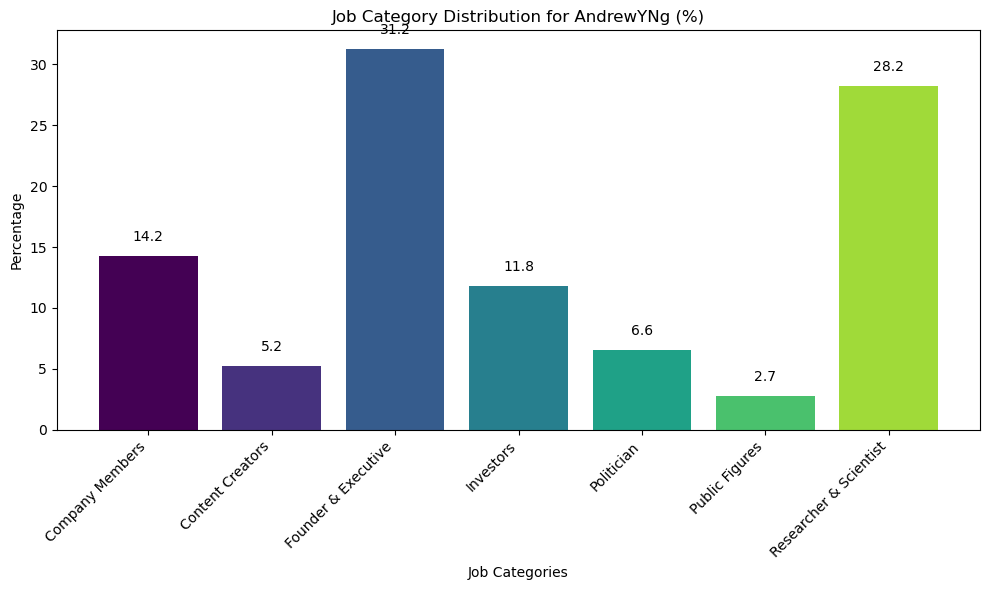

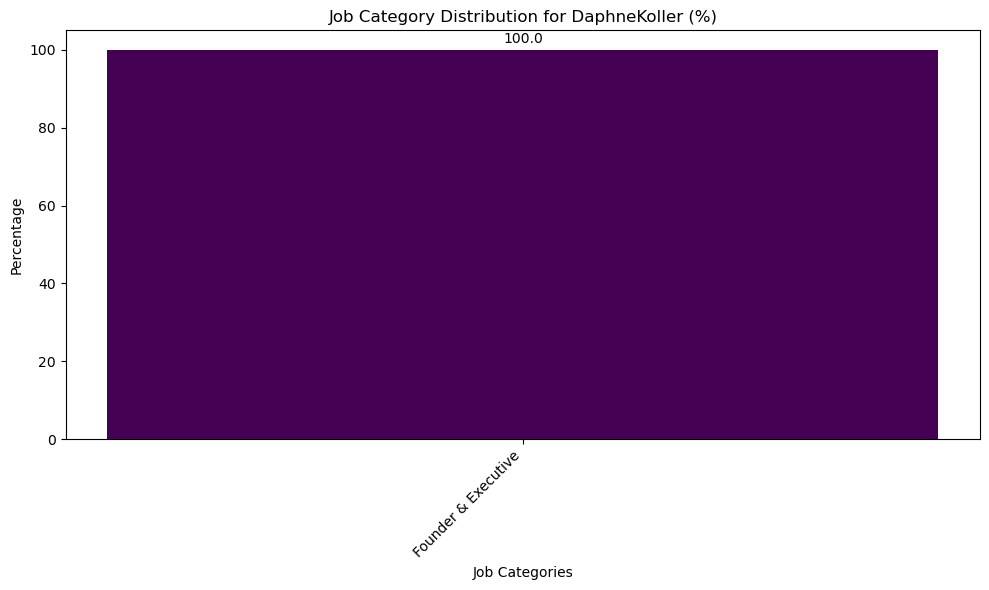

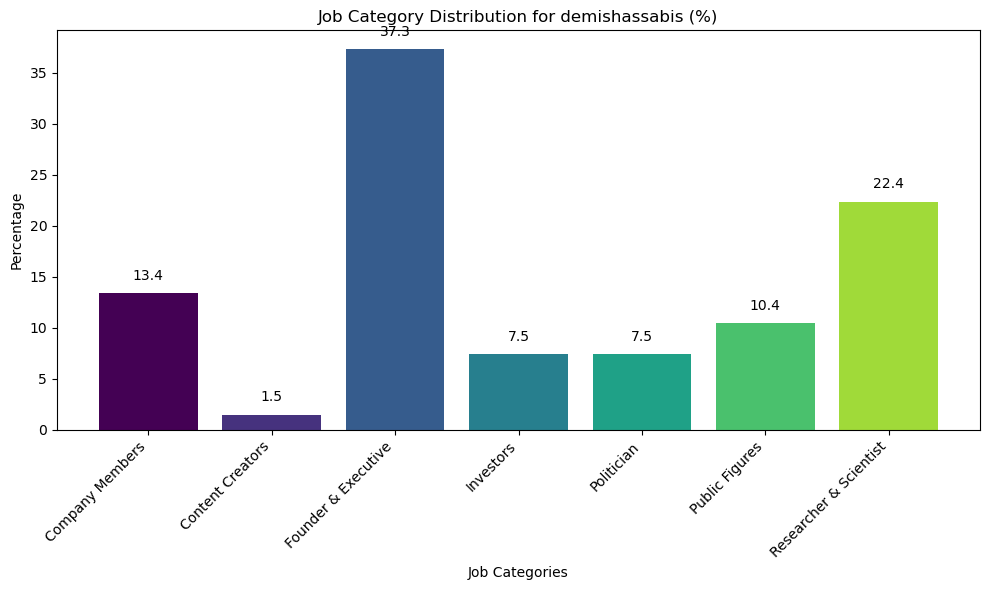

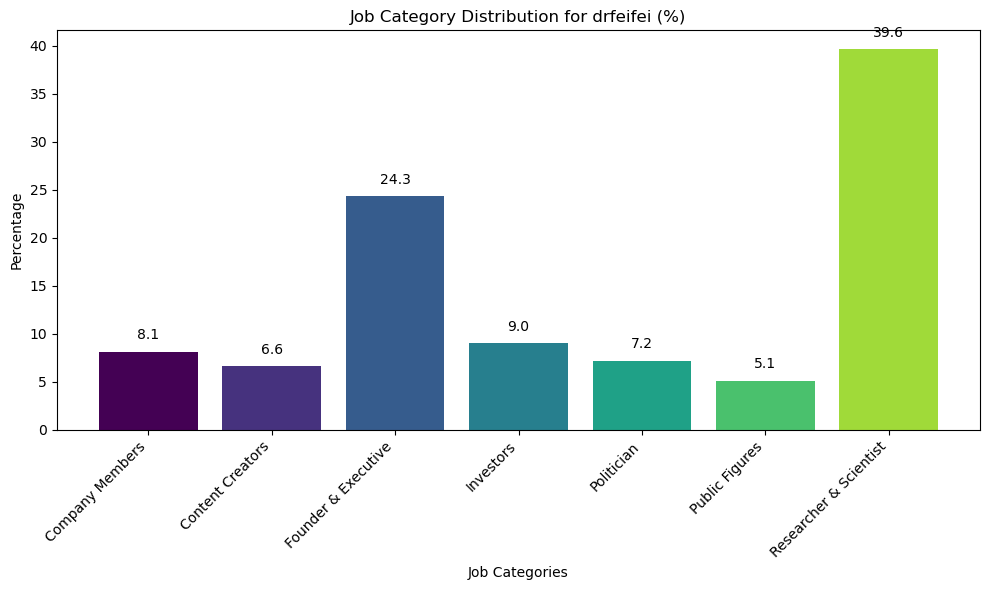

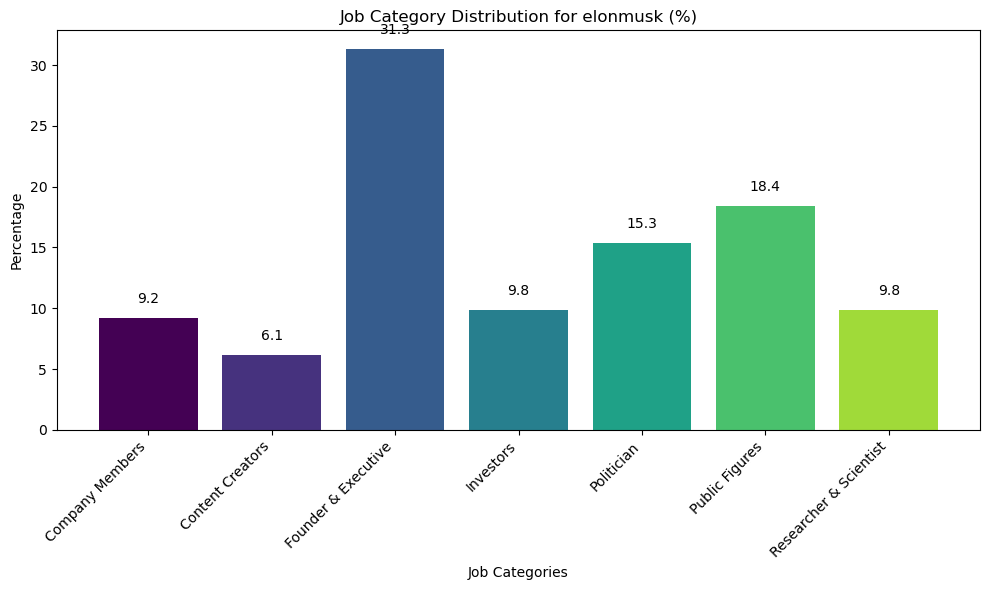

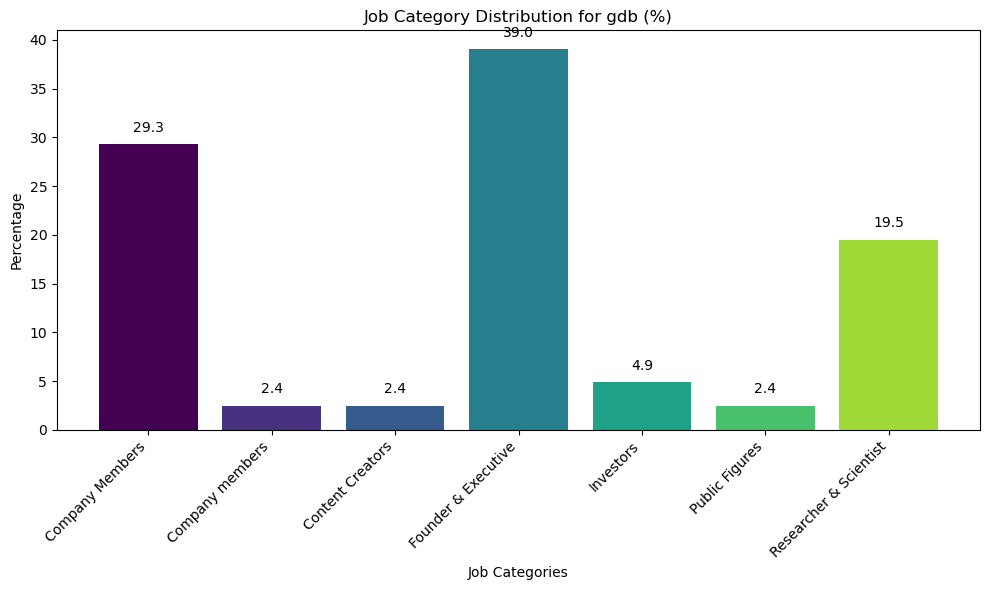

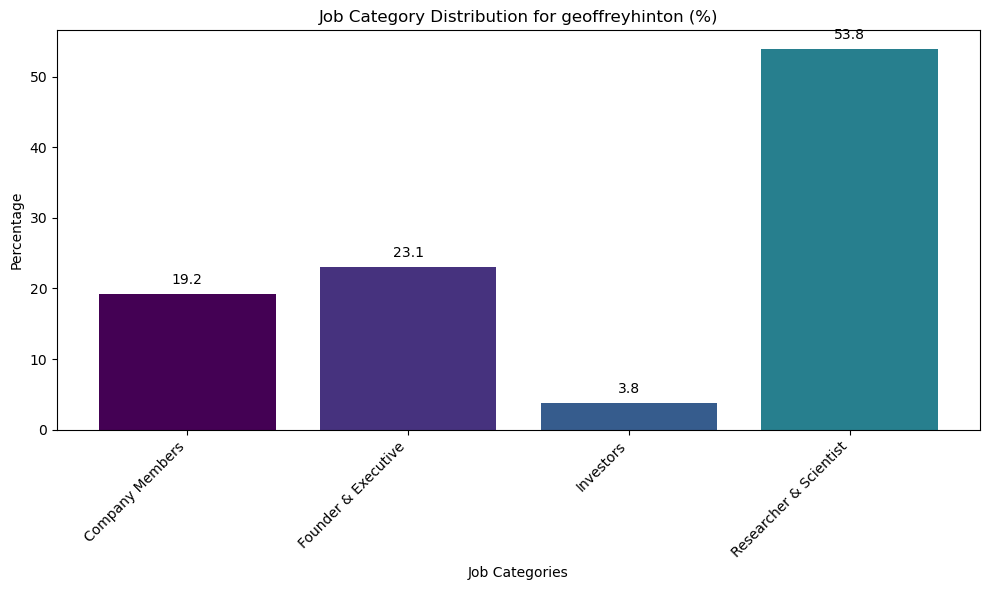

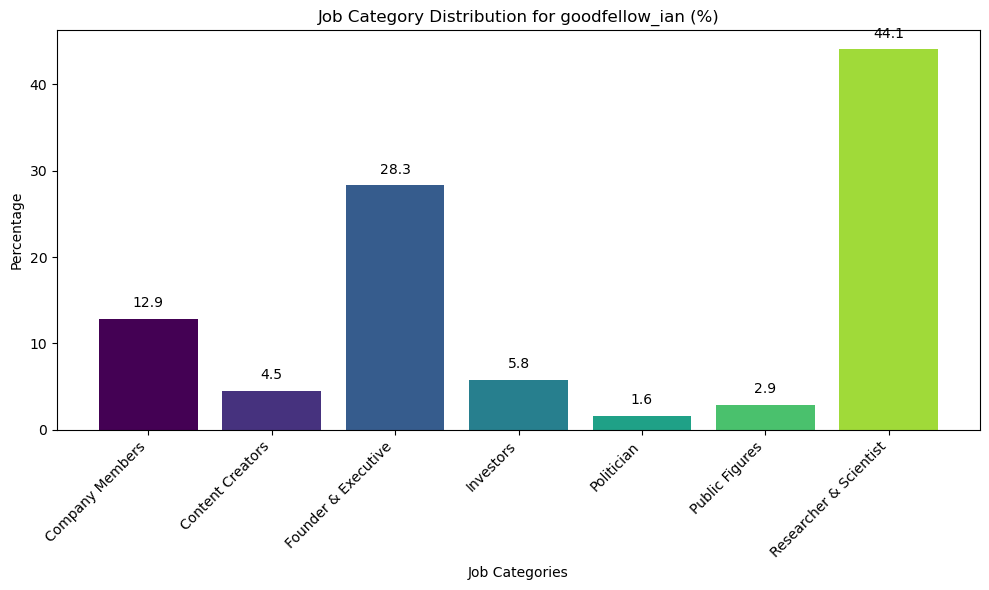

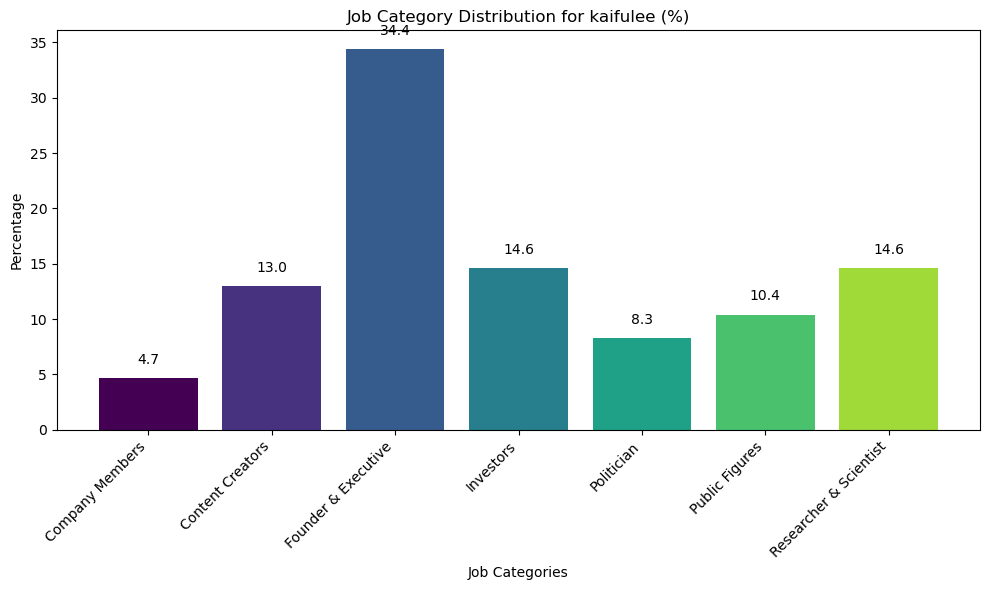

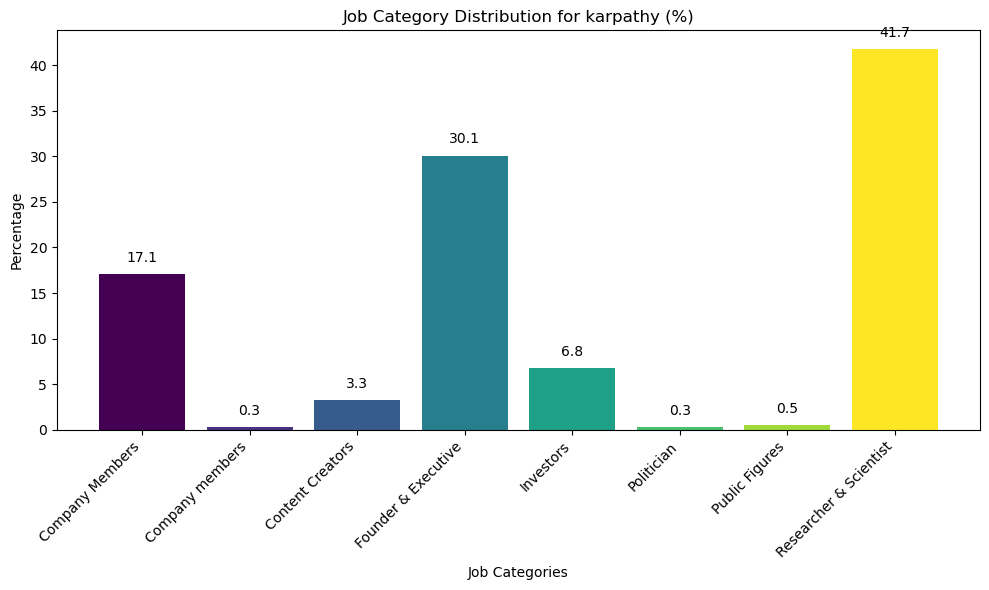

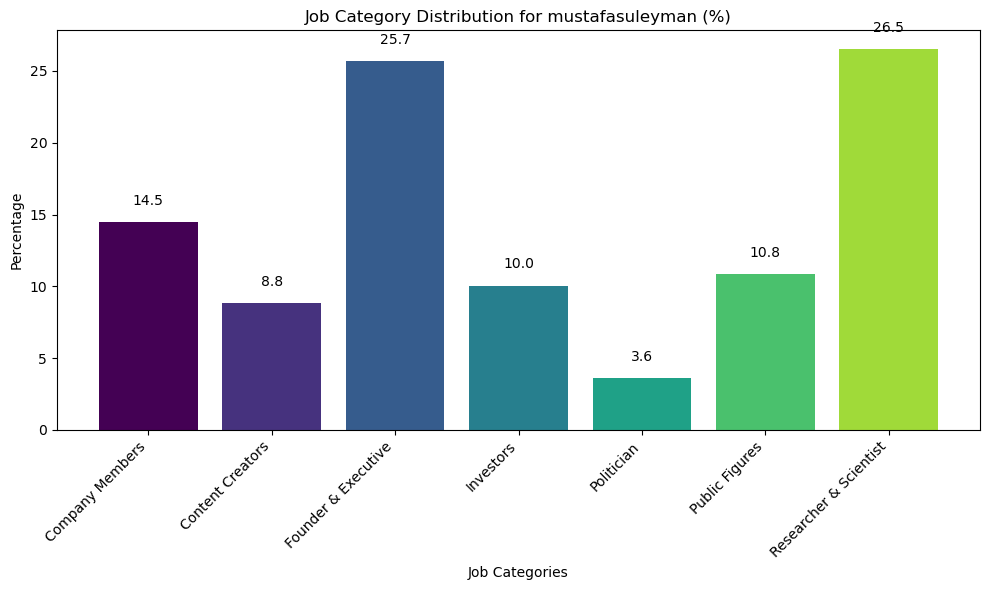

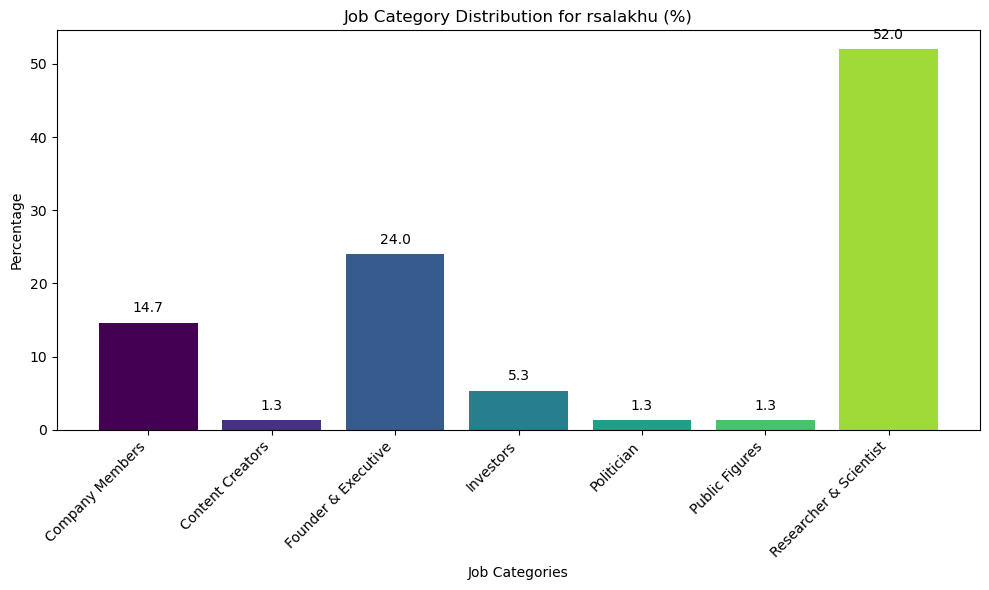

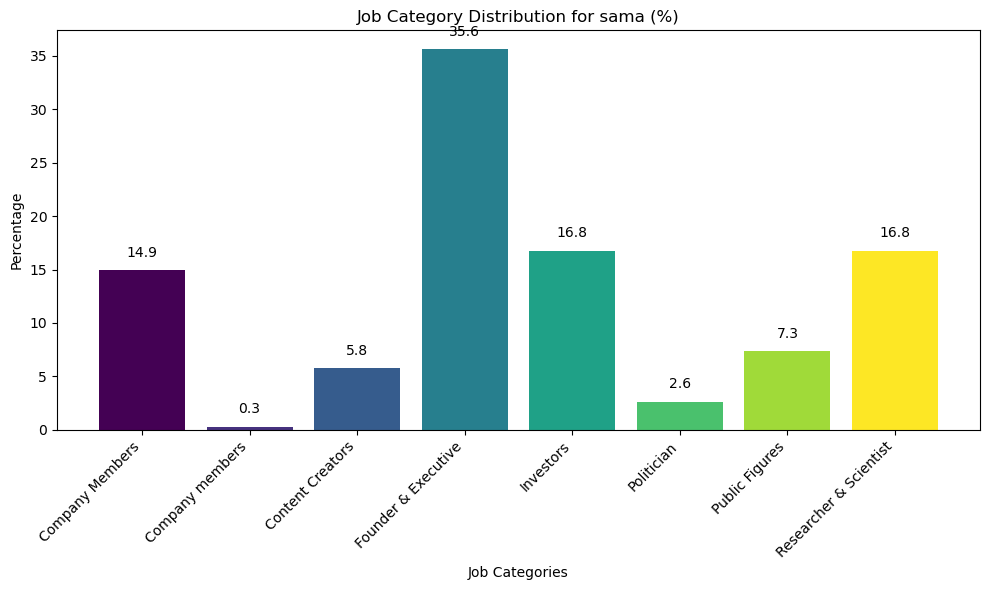

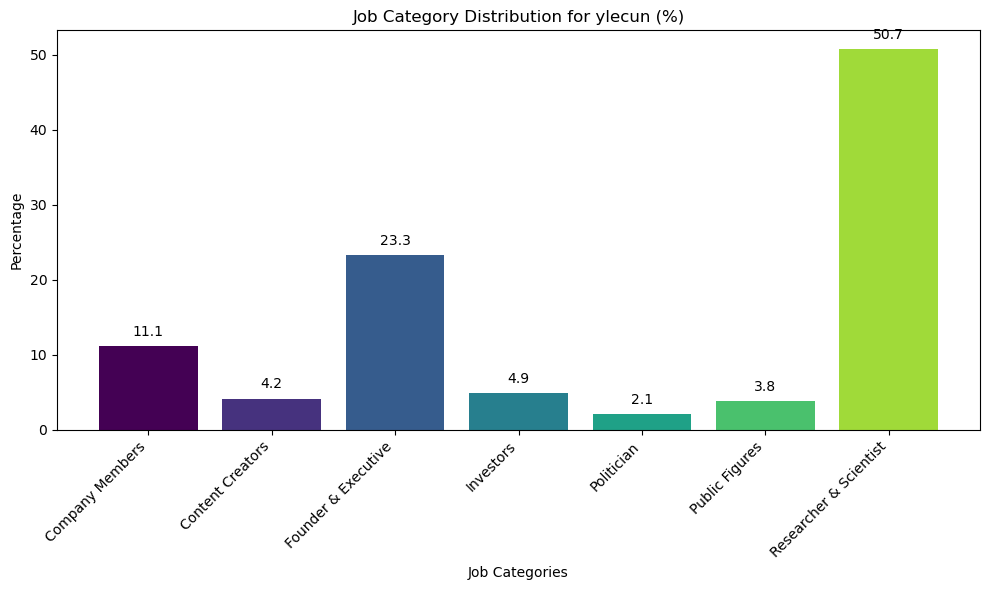

In [20]:
import matplotlib.pyplot as plt
import numpy as np


def plot_colored_position_distribution_with_percentages(grouped_data, attribute):
    colors = plt.cm.viridis(np.linspace(0, 1, len(grouped_data[attribute].unique())))
    
    for kol, group in grouped_data.groupby('screenName_kol'):
        # Count the frequency of each job category
        category_counts = group[attribute].value_counts()
        # Calculate percentages
        category_percentages = category_counts / category_counts.sum() * 100
        # Sort the categories for consistent plotting
        category_counts_sorted = category_counts.sort_index()
        category_percentages_sorted = category_percentages.sort_index()
        # Plot the distribution with percentages and colors
        plt.figure(figsize=(10, 6))
        bars = plt.bar(category_counts_sorted.index, category_percentages_sorted.values, color=colors)
        
        # Adding the percentages on top of each bar
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 1), ha='center', va='bottom')
        
        plt.title(f'Job Category Distribution for {kol} (%)')
        plt.ylabel('Percentage')
        plt.xlabel('Job Categories')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Plot the colored position distribution with percentages for each KOL
plot_colored_position_distribution_with_percentages(kol_fo_data, 'position_categorized')


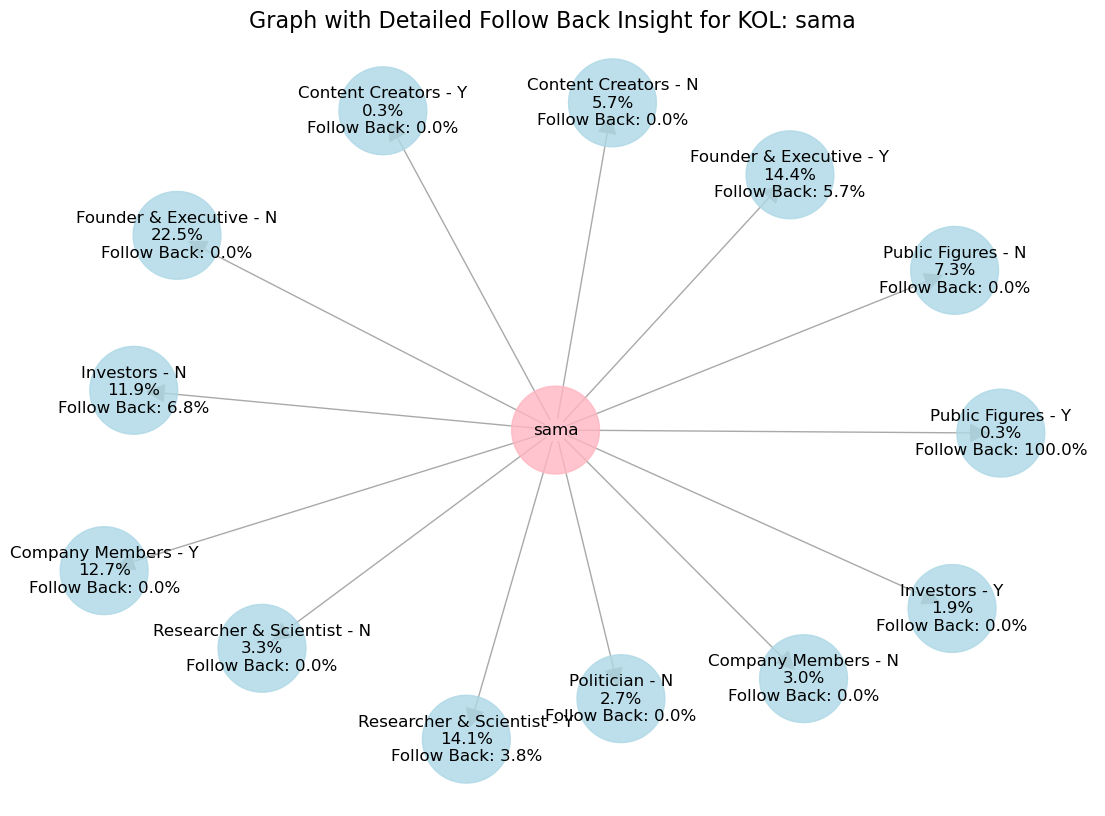

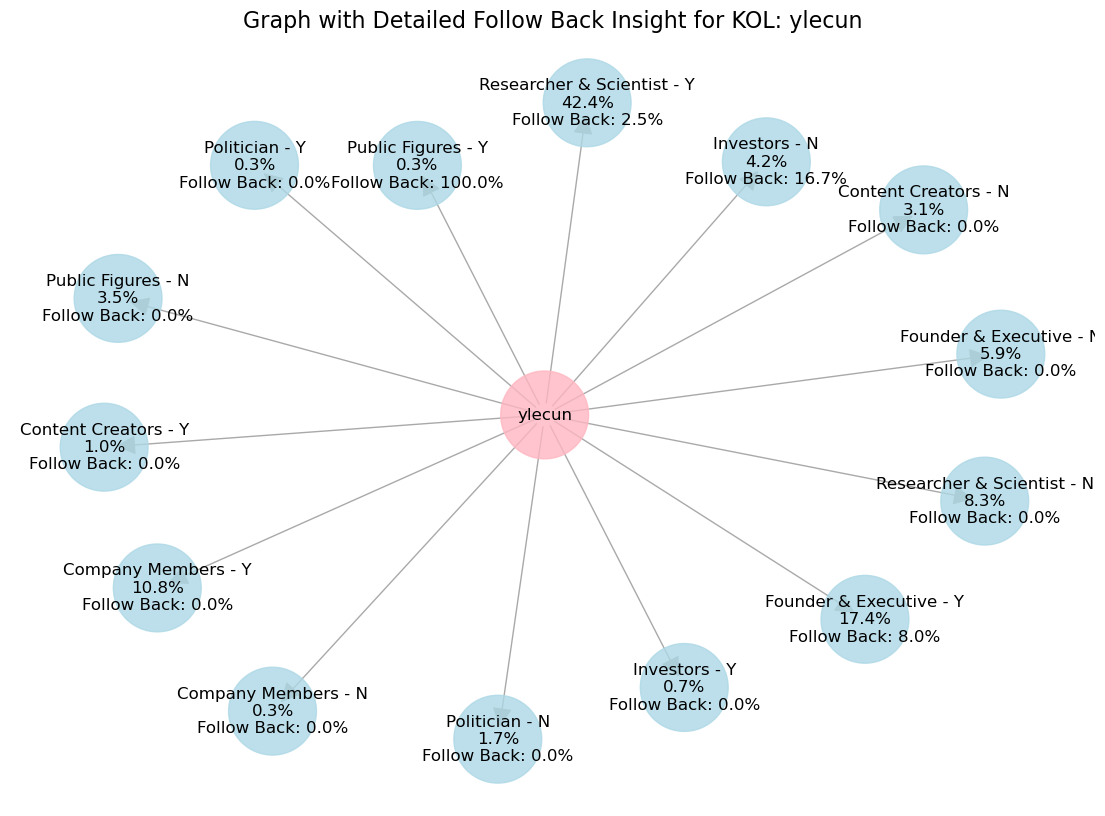

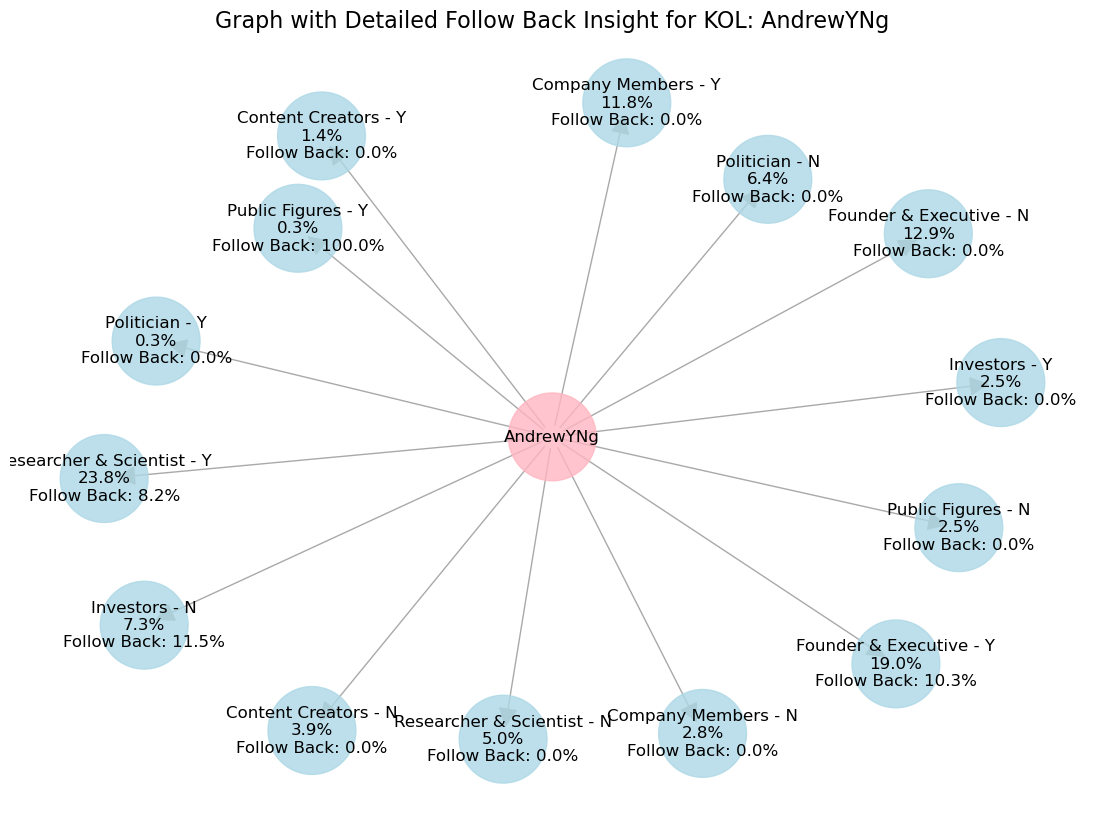

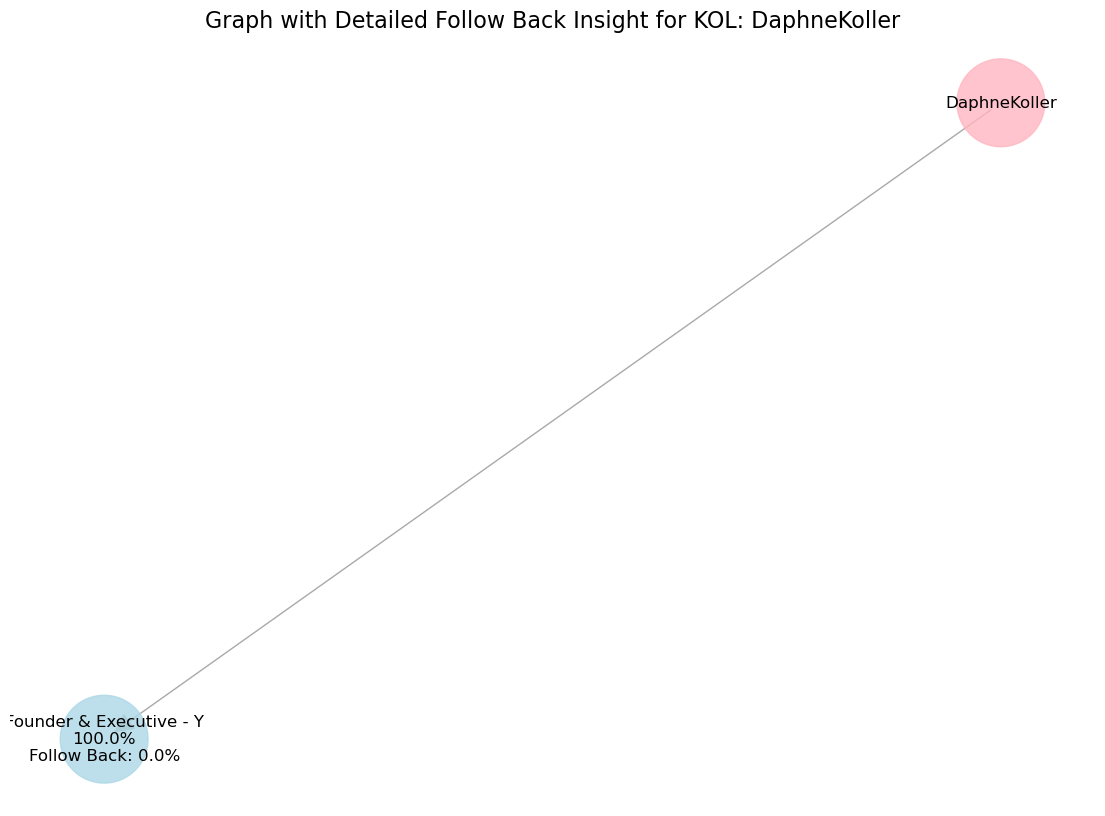

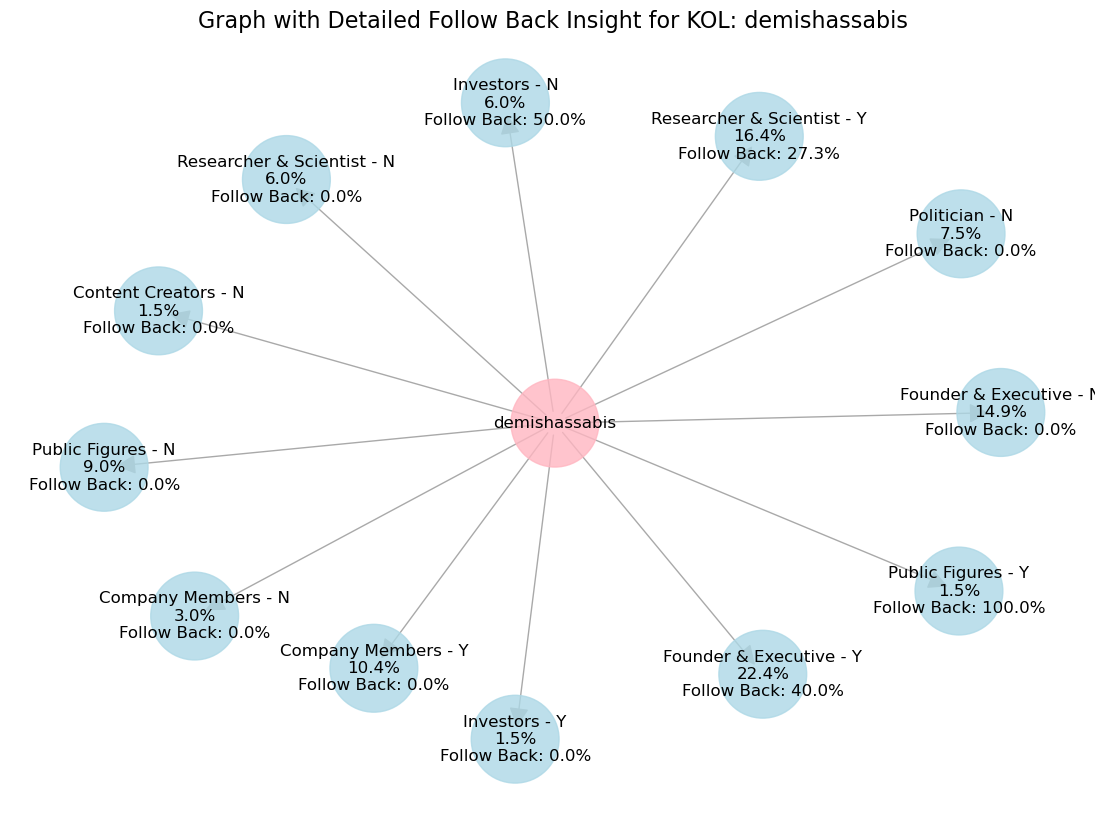

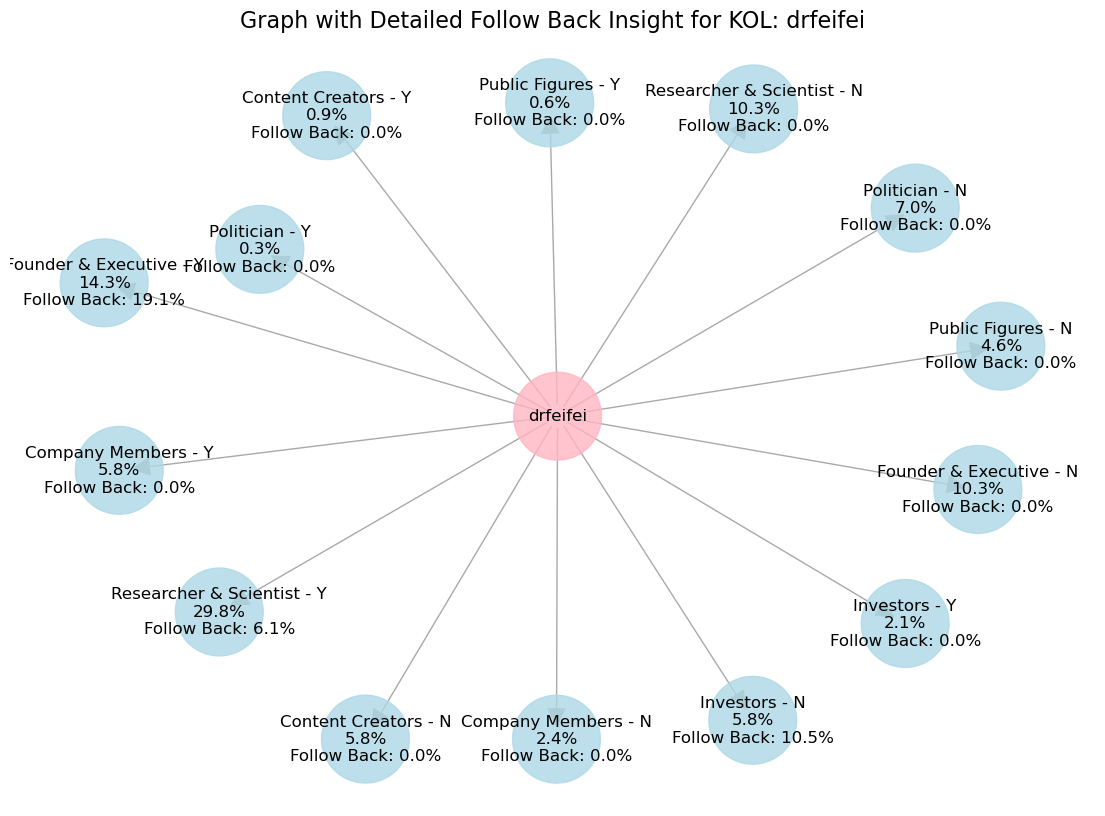

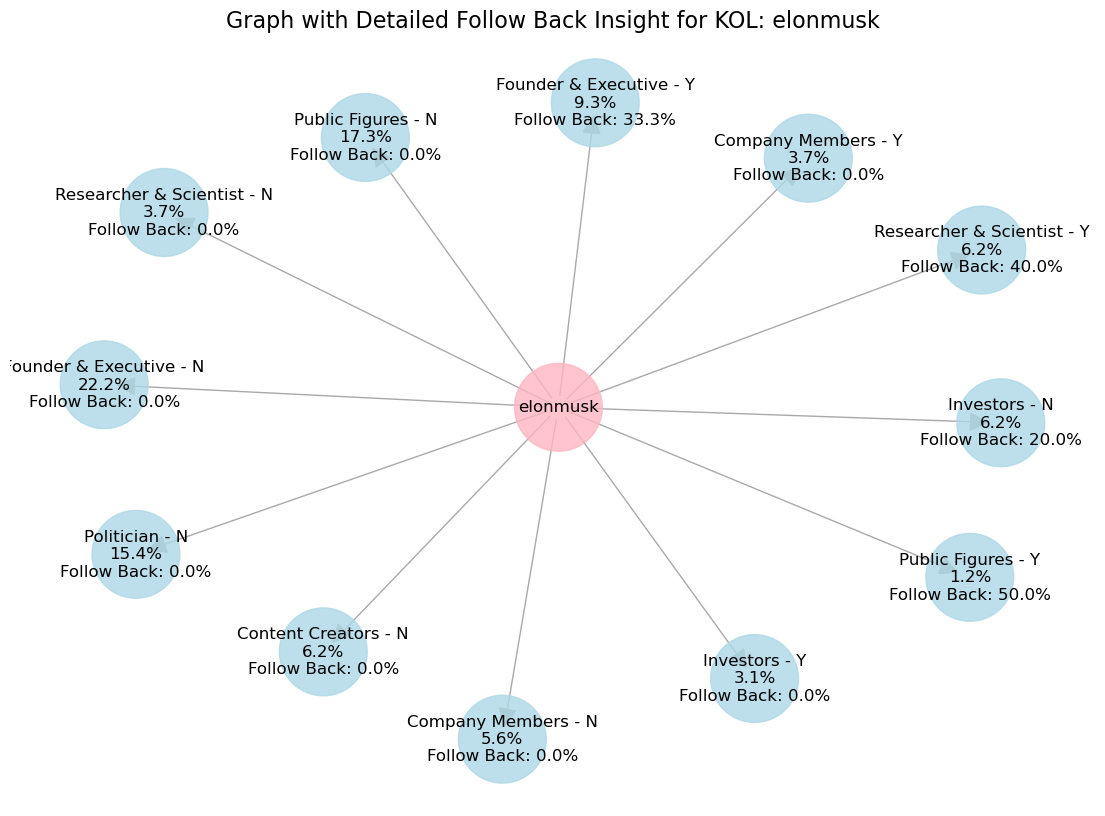

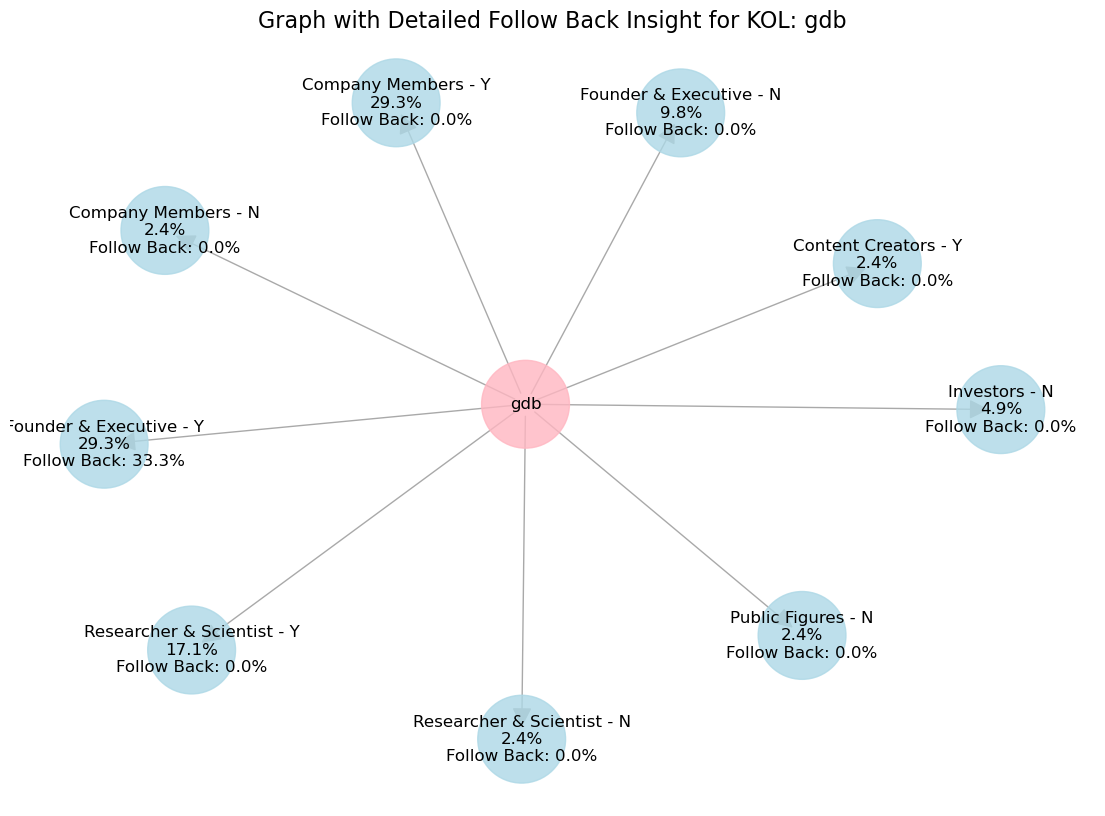

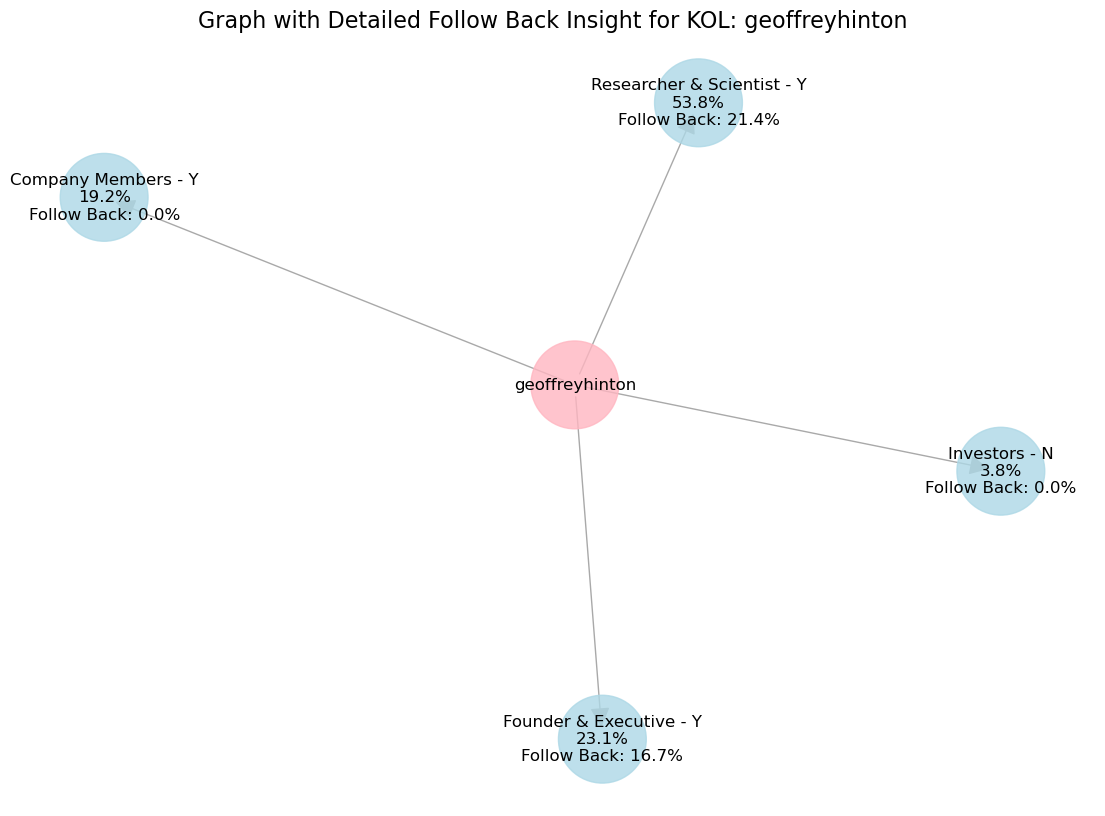

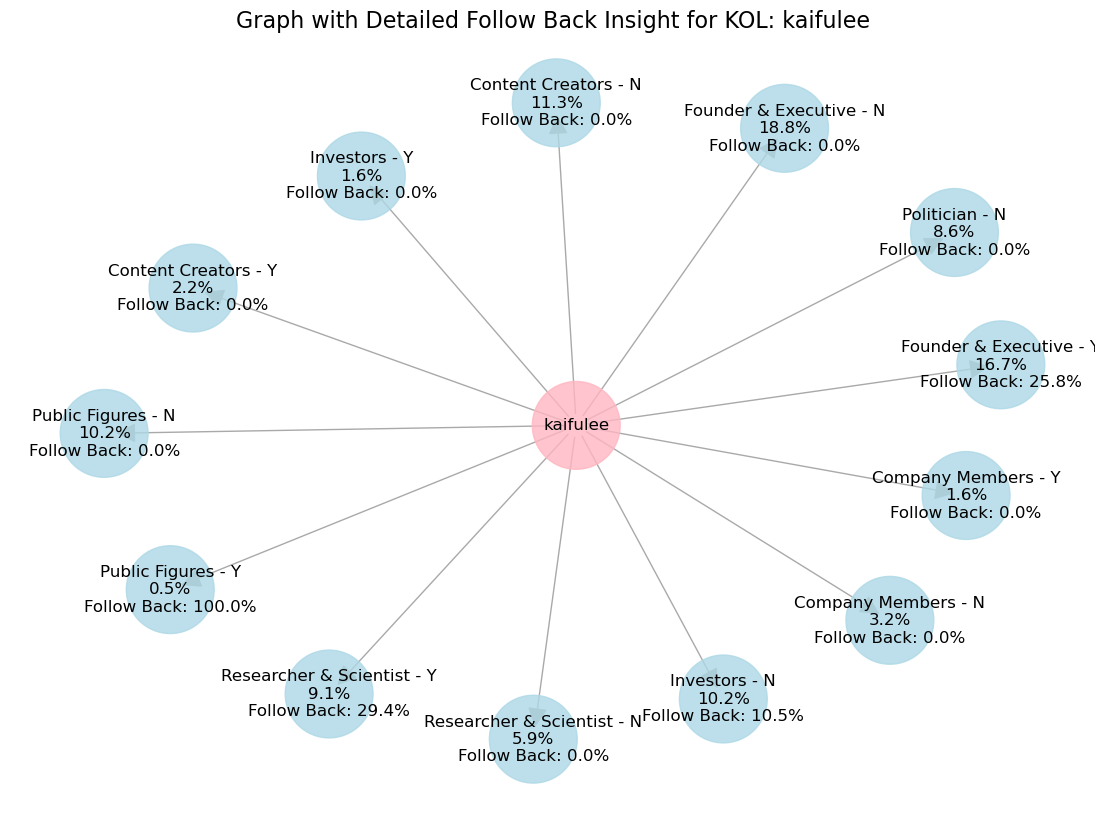

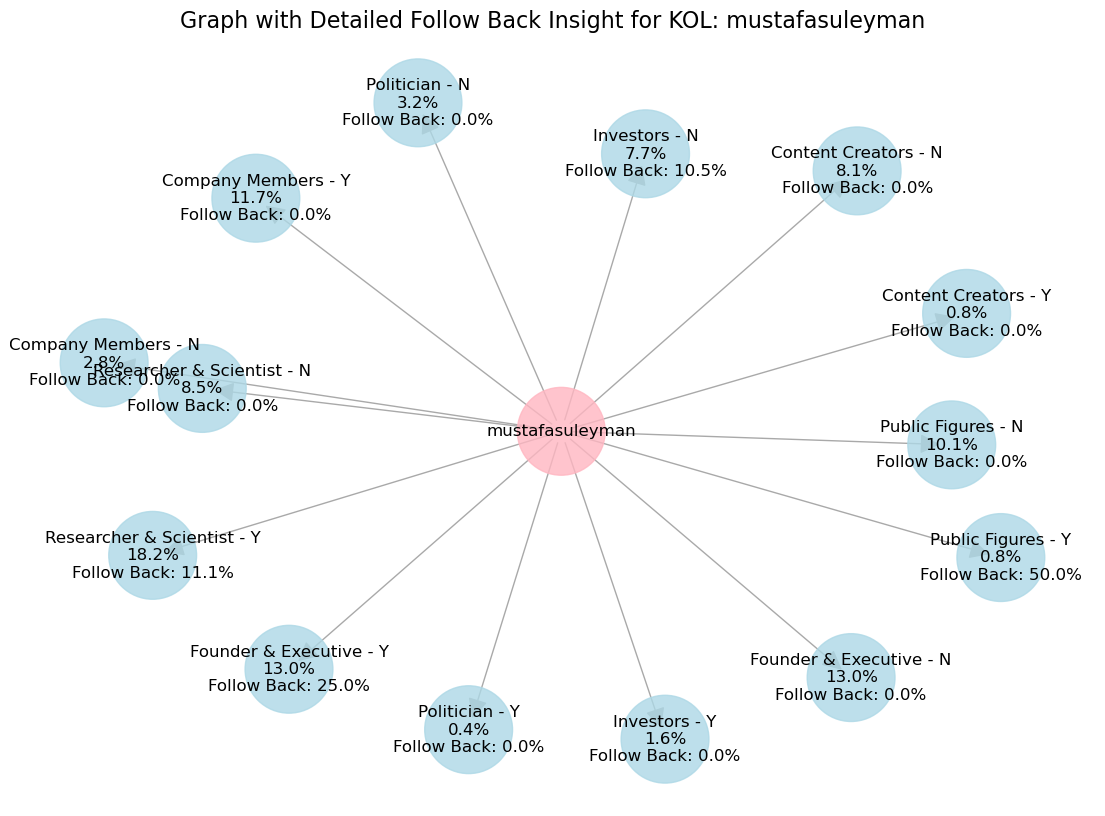

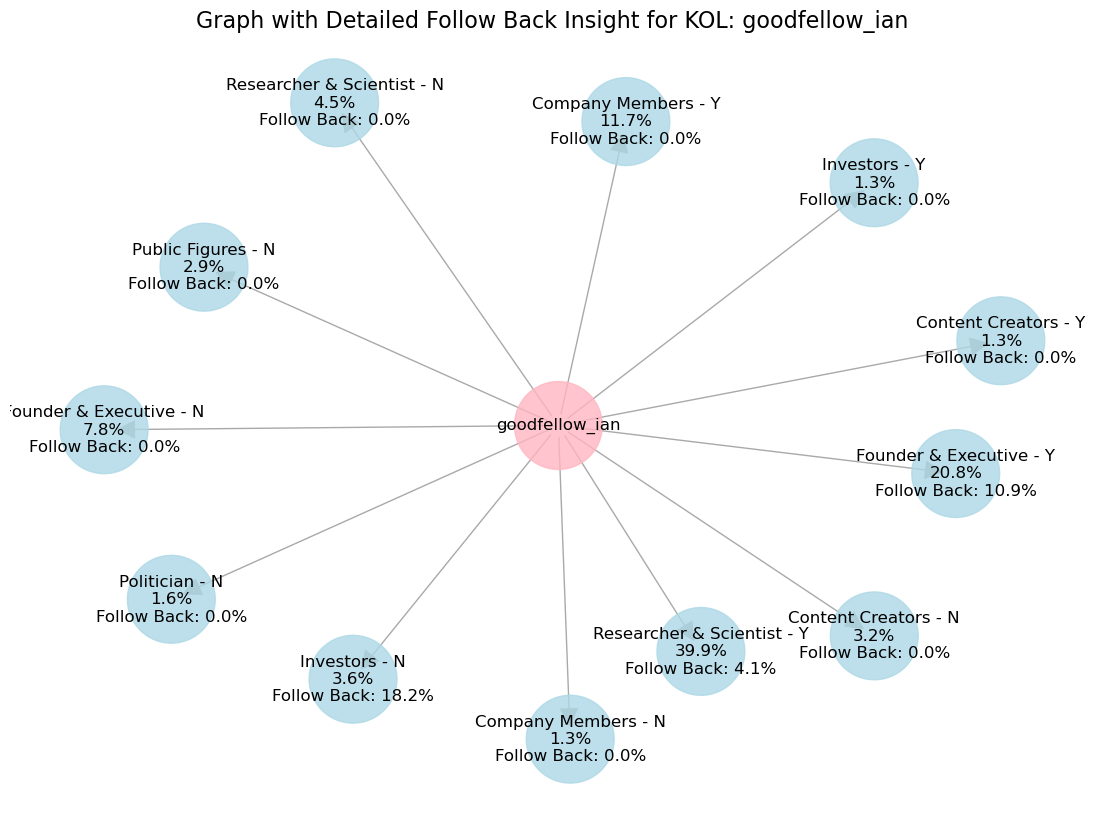

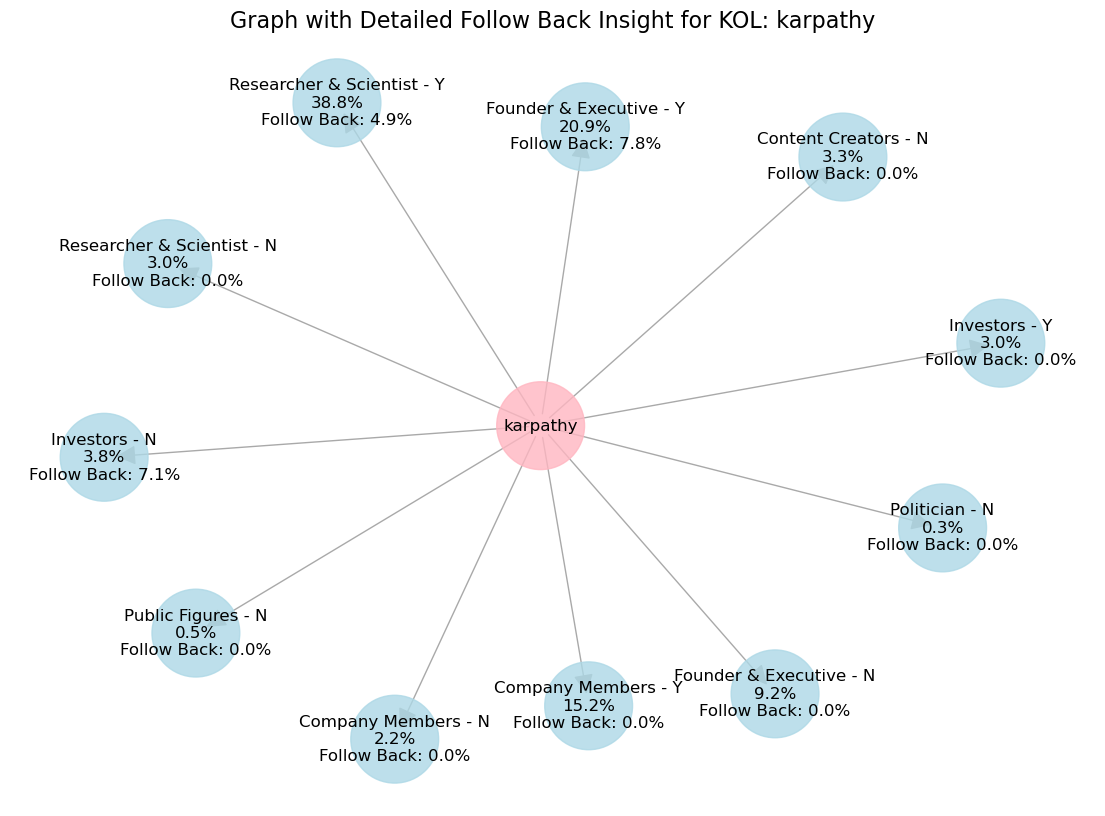

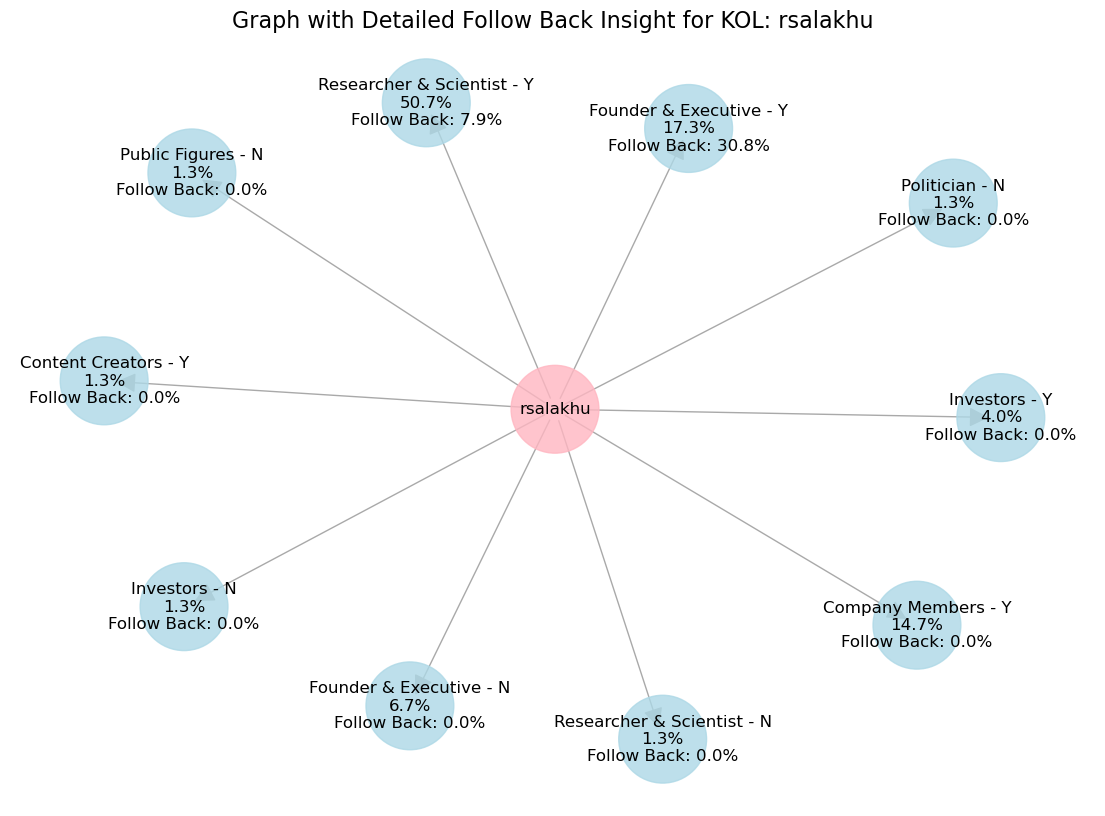

In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Drop rows where either 'position_categorized' or 'ai_related' is NaN
data.dropna(subset=['position_categorized', 'ai_related'], inplace=True)

# Merge 'position_categorized' and 'ai_related' columns to create 'merged_position'
data['merged_position'] = data['position_categorized'] + ' - ' + data['ai_related']

# Merge similar categories and replace any known duplicates
data['merged_position'] = data['merged_position'].replace({
    'Company Members - Y': 'Company Members - Y',
    'Company members - Y': 'Company Members - Y'
})

# Extract necessary data
necessary_data = data[['screenName_kol', 'merged_position', 'following_fo']]

# Define a function to plot the graph including enhanced follow back percentages
def plot_enhanced_graph_with_detailed_follow_back(kol_name, grouped_data, attribute, following_col):
    # Filter the data for the specific KOL
    kol_data = grouped_data[grouped_data['screenName_kol'] == kol_name]
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add a node for the KOL
    G.add_node(kol_name, type='KOL', style='filled', fillcolor='#FFB6C1', label=kol_name, size=4000)  # Light pink for KOL
    
    # Track counts of follow back by position
    position_counts = {}
    position_follow_back_counts = {}
    
    for _, row in kol_data.iterrows():
        # Each FO is represented by its job category
        fo_node = row[attribute]
        if fo_node not in position_counts:
            position_counts[fo_node] = 0
            position_follow_back_counts[fo_node] = 0
        position_counts[fo_node] += 1
        
        # Track follow back
        if row[following_col] == 1:
            position_follow_back_counts[fo_node] += 1
        
        # Always add the forward direction from KOL to FO
        G.add_edge(kol_name, fo_node, dir='forward')

    # Normalize counts to get percentages and add as node attribute
    total_fos = sum(position_counts.values())
    for position, count in position_counts.items():
        follow_back_percentage = (position_follow_back_counts[position] / count * 100)
        label_text = f"{position}\n{count / total_fos * 100:.1f}%\nFollow Back: {follow_back_percentage:.1f}%"
        G.add_node(position, type='FO', count=count, percent=(count / total_fos * 100), 
                   follow_back_percent=follow_back_percentage, label=label_text, size=4000)

    # Generate plot
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G)
    node_sizes = [G.nodes[node]['size'] for node in G]
    node_colors = ['#FFB6C1' if G.nodes[node]['type'] == 'KOL' else '#ADD8E6' for node in G]  # Light blue for positions
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)
    
    # Edges
    edge_colors = ['#A9A9A9' for u, v in G.edges]  # Dark gray for edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='-|>', arrowsize=30)
    
    plt.title(f'Graph with Detailed Follow Back Insight for KOL: {kol_name}', size=16)
    plt.axis('off')
    plt.show()

# Define the KOL names you want to process
kol_names = ['sama', 'ylecun', 'AndrewYNg', 'DaphneKoller',  'demishassabis','drfeifei', 'elonmusk','gdb','geoffreyhinton','kaifulee','mustafasuleyman','goodfellow_ian','karpathy','rsalakhu']

# Plot the enhanced graph with detailed follow back insights for the specified KOLs
for kol_name in kol_names:
    plot_enhanced_graph_with_detailed_follow_back(kol_name, necessary_data, 'merged_position', 'following_fo')
